In [ ]:
!pip install piq diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import piq
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

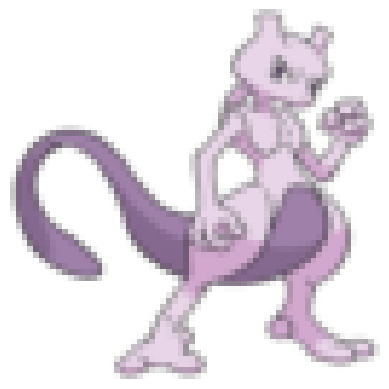

In [ ]:
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

image = cv2.imread('mewtwo.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_tensor = preprocess(Image.fromarray(image))
plt.imshow(image_tensor.permute(1, 2, 0).numpy() / 2 + 0.5)
plt.axis('off')
plt.show()

In [ ]:
from diffusers import UNet2DModel

DIP = UNet2DModel(
                 sample_size=64,  # the target image resolution
                 in_channels=3,  # the number of input channels, 3 for RGB images
                 out_channels=3,  # the number of output channels
                 layers_per_block=2,  # how many ResNet layers to use per UNet block
                 block_out_channels=(128, 128, 256, 512),  # the number of output channes for each UNet block
                 down_block_types=(
                    "DownBlock2D",  # a regular ResNet downsampling block
                    "DownBlock2D",
                    "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                    "DownBlock2D",
                ),
                 up_block_types=(
                    "UpBlock2D",  # a regular ResNet upsampling block
                    "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                    "UpBlock2D",
                    "UpBlock2D",
                ),
        )

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [ ]:
DIP = DIP.to(device)
x = torch.randn(1, 3, 64, 64)
print(DIP(x,0).sample.shape)

torch.Size([1, 3, 64, 64])


In [ ]:
iterations = 100
criterion = nn.MSELoss()
lr = 1e-4
optimizer = optim.Adam(DIP.parameters(), lr=lr)

In [ ]:
def psnr_eval(x, y):
    psnr = piq.psnr(x, y, data_range=1., reduction='none')
    return psnr

def ssim_eval(x, y):
    ssim = piq.ssim(x, y, data_range=1.)
    return ssim

  0%|          | 0/100 [00:00<?, ?it/s]

Loss is 0.7374795079231262
PSNR index: 7.3476
SSIM index: 0.0136


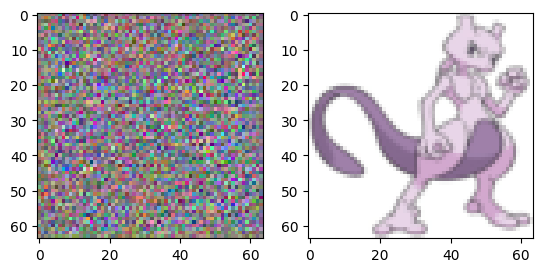

Loss is 0.09572187811136246
PSNR index: 16.2844
SSIM index: 0.2397


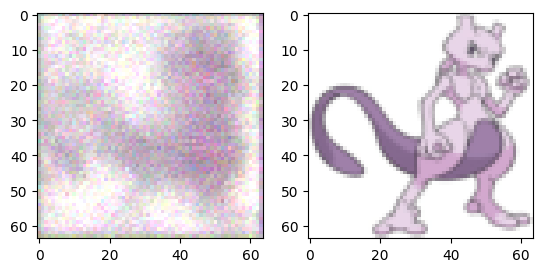

Loss is 0.04294009879231453
PSNR index: 20.2795
SSIM index: 0.5504


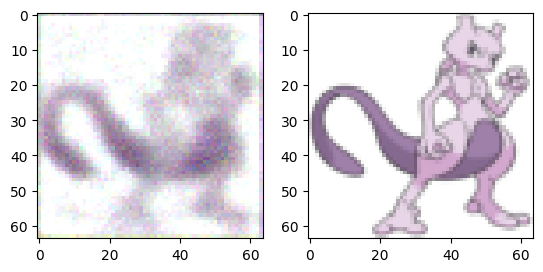

Loss is 0.02542491815984249
PSNR index: 22.2643
SSIM index: 0.6590


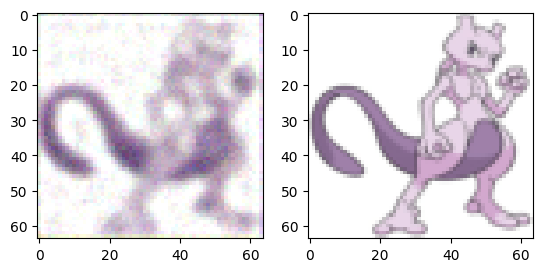

Loss is 0.01804262213408947
PSNR index: 23.8780
SSIM index: 0.7454


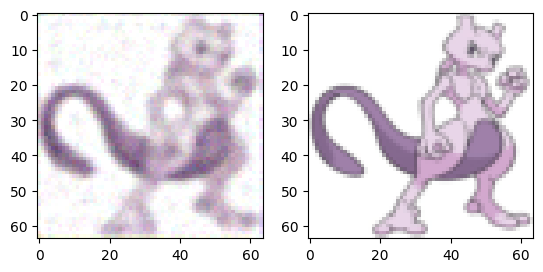

Loss is 0.013600624166429043
PSNR index: 25.1156
SSIM index: 0.8020


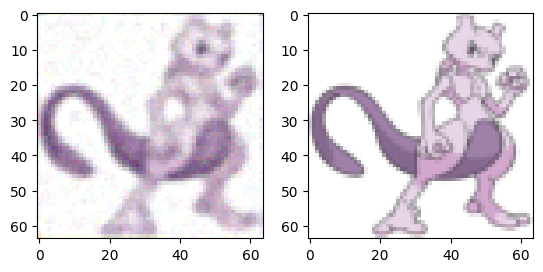

Loss is 0.010476116091012955
PSNR index: 26.2484
SSIM index: 0.8438


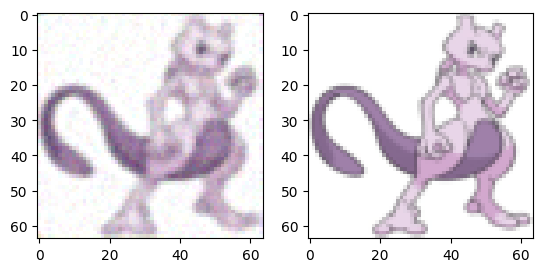

Loss is 0.00803059246391058
PSNR index: 27.4810
SSIM index: 0.8771


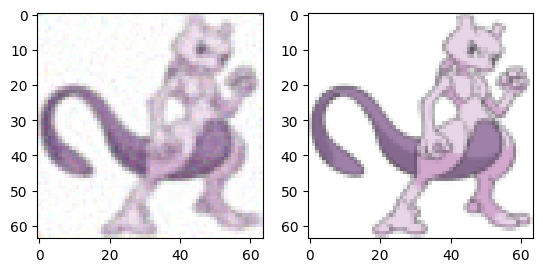

Loss is 0.006253572180867195
PSNR index: 28.5952
SSIM index: 0.8982


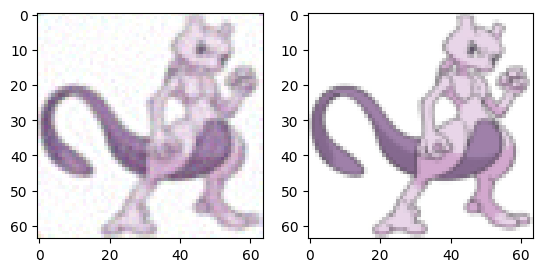

Loss is 0.0049411458894610405
PSNR index: 29.6060
SSIM index: 0.9172


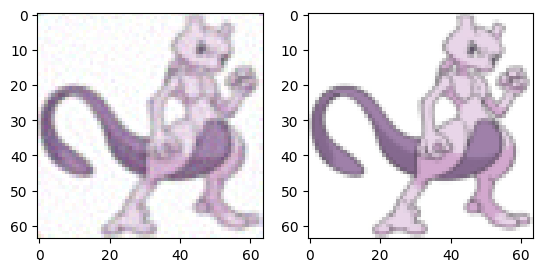

In [ ]:
time_steps = []
denoised_images = []
mse_losses = []
psnr_values = []
ssim_values = []
fid_values = []

for i in tqdm(range(iterations)):
  out = DIP(x,0).sample
  loss = criterion(out, image_tensor.unsqueeze(0))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if i % 10 == 0:
    psnr = psnr_eval((out / 2 + 0.5).clip(0,1), (image_tensor.unsqueeze(0) / 2 + 0.5).clip(0,1))
    ssim = ssim_eval((out / 2 + 0.5).clip(0,1), (image_tensor.unsqueeze(0) / 2 + 0.5).clip(0,1))
    print("Loss is {}".format(loss.item()))
    print(f"PSNR index: {psnr.item():0.4f}")
    print(f"SSIM index: {ssim.item():0.4f}")
    plt.subplot(1, 2, 1)
    pred_np = out.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() / 2 + 0.5
    plt.imshow(pred_np)
    denoised_images.append(pred_np)
    time_steps.append(i)
    psnr_values.append(psnr.item())
    ssim_values.append(ssim.item())
    mse_losses.append(loss.item())
    plt.subplot(1, 2, 2)
    plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() / 2 + 0.5)
    plt.show()
    plt.close()


In [ ]:
def show_images(images):
    """Shows the provided images as sub-pictures in a square"""
    # Defining number of rows and columns
    fig = plt.figure(figsize=(20,8))
    rows = 1
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx])
                plt.axis('off')
                idx += 1
    # Showing the figure
    plt.show()

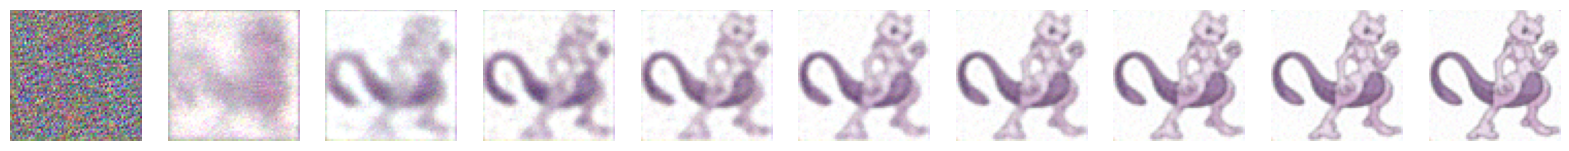

<Figure size 640x480 with 0 Axes>

In [ ]:
show_images(denoised_images)

In [ ]:
def plot_iteration_performance(time_steps, mse_losses, psnr_values, ssim_values):
    """Shows the iteration in MSE, PSNR and SSIM"""
    fig = plt.figure(figsize=(6,8))
    ax = fig.add_subplot(2,1,1)
    ax.plot(time_steps, psnr_values, color='dodgerblue', linestyle='dashed', marker='^', markersize=7, label=r"PSNR DIP")
    ax.set_xlabel("Iteration", fontsize = 11)
    ax.set_ylabel(r"$PSNR$", fontsize=14)
    ax2=ax.twinx()
    ax2.plot(time_steps, ssim_values, color='crimson', linestyle='dashed', marker='D', markersize=5, label=r"SSIM DIP")
    ax.grid(True, which='both', axis='x', linestyle='--', color='gray', alpha=0.5)
    ax2.set_ylabel(r"$SSIM$", fontsize=14)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    ax3 = fig.add_subplot(2,1,2)
    ax3.plot(time_steps, mse_losses, color='firebrick', linestyle='dashed', marker='o', markersize=5, label=r"MSE DIP")
    ax3.set_xlabel("Iteration", fontsize = 11)
    ax3.set_ylabel(r"$MSE$", fontsize=14)
    ax3.grid(True, which='both', axis='y', linestyle='--', color='gray', alpha=0.5)
    ax3.legend(loc=0)
    plt.show()


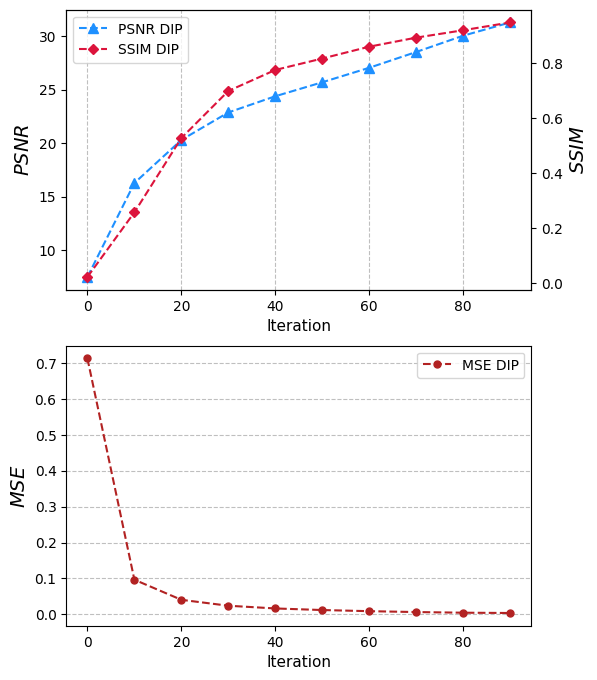

In [ ]:
plot_iteration_performance(time_steps, mse_losses, psnr_values, ssim_values)